<a href="https://colab.research.google.com/github/MirajShah12/2026MLBHitterProjections/blob/main/Top_Hitters_for_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This project will serve as a model for predicting the 2026 best hitters, breakouts, etc
#This is the notebook

In [ ]:
pip install --upgrade git+https://github.com/jldbc/pybaseball.git@master

  Cloning https://github.com/jldbc/pybaseball.git (to revision master) to /tmp/pip-req-build-p45udh9x
  Running command git clone --filter=blob:none --quiet https://github.com/jldbc/pybaseball.git /tmp/pip-req-build-p45udh9x
  Resolved https://github.com/jldbc/pybaseball.git to commit e588989359059ba04a510cc12aefa972f0a715d6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.1 MB/s eta 0:00:00
  Created wheel for pybaseball: filename=pybaseball-2.2.7-py3-none-any.whl size=428385 sha256=17a97ac92b5915711fbbb487e53ddcfb47a18341340695488ae00df4fcb8b5c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-mgrfhegk/wheels/65/92/6c/9bfc591d490569e154f14be7ac11cfebdd9756dbeccb57218b
Successfully built pybaseball


In [ ]:
import pybaseball as pb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Train the model

hitter_data_2022 = pb.fg_batting_data(start_season=2016, end_season=2023)
#target var is wRC+
feature_cols =['BABIP+', 'BB%+', 'K%+', 'Pull%+',
                      'EV', 'LA','Barrel%', 'maxEV',
                       'Hard%+', 'O-Swing%',  'LD+%', 'GB%+','FB%+',
                        'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%',
                  'Contact%',]

X = hitter_data_2022[feature_cols]
y = hitter_data_2022['wRC+']

#Scaling the features
scaler = StandardScaler()
#X[feature_cols] = scaler.fit_transform(X[feature_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2 = r2_score(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)

R2: 0.8015654300687365
MSE: 90.84989962808753


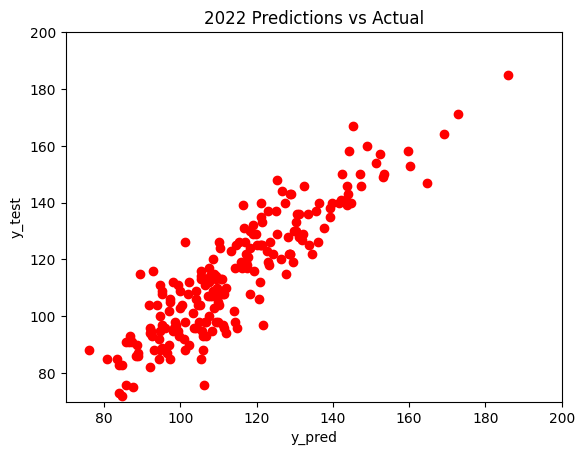

In [ ]:
#plot
print("R2:", r2)
print("MSE:", mse)
plt.scatter(y_pred, y_test, color="red")
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(70, 200)
plt.ylim(70, 200)
plt.title("2022 Predictions vs Actual")
plt.show()

In [ ]:
def predict_wrc_plus(season=2024, model=reg):
  """
  Predicts the wRC+ for a given season.
  Takes the season before to predict these metrics
  return dataframe
  """
  data = pb.fg_batting_data(start_season=season, end_season=season, qual=150)
  data['xwRC+'] = reg.predict(data[feature_cols])
  data['Error_Margin'] = data['xwRC+'] - data['wRC+']

  r2_val = r2_score(data['xwRC+'], data['wRC+'])
  mse = mean_squared_error(data['xwRC+'], data['wRC+'])

  print("R2 score", r2_val)
  print("MSE", mse)

  return data
def predict_wrc_plus_from_prev(season=2024):
  """
  Predicts the wRC+ for a given season.
  Takes the season before to predict these metrics
  return dataframe
  """

  prev_pred = predict_wrc_plus(season-1)
  data = pb.fg_batting_data(start_season=season, end_season=season, qual=150)

  #match the players from prev_pred to data
  data = data[['Name', 'wRC+']].merge(
        prev_pred[['Name', 'xwRC+']],
        on='Name',
        how='inner' # 'inner' ensures we only compare players with data for both years
    )

  data.fillna(100, inplace=True)
  data['Error_Margin'] = data['xwRC+'] - data['wRC+']

  print("---FROM THE NEXT YEAR---")
  r2_val = r2_score(data['xwRC+'], data['wRC+'])
  mse = mean_squared_error(data['xwRC+'], data['wRC+'])
  print("R2 score", r2_val)
  print("MSE", mse)
  return data



In [ ]:
data_2025_pred = predict_wrc_plus(2025)
dis_pred = data_2025_pred[['Name', 'wRC+', 'xwRC+', 'Error_Margin']]
dis_pred

R2 score 0.782089160997538
MSE 131.75607106165307


,Name,wRC+,xwRC+,Error_Margin
0,Aaron Judge,204,216.110129,12.110129
7,Cal Raleigh,161,145.794944,-15.205056
38,Bobby Witt Jr.,130,144.032342,14.032342
2,Shohei Ohtani,172,178.315618,6.315618
16,Geraldo Perdomo,138,135.126702,-2.873298
...,...,...,...,...
361,Jordan Walker,66,95.032076,29.032076
387,Josh Rojas,44,57.813184,13.813184
385,Jac Caglianone,46,68.123026,22.123026
383,LaMonte Wade Jr.,52,61.657328,9.657328


In [ ]:
dis_pred.to_csv('2025_predictions.csv', index=False)

In [ ]:
print("The R value between metrics is",data_2025_pred['xwRC+'].corr(data_2025_pred['wRC+']))
print(f"The r2 score of preds are {r2_score(data_2025_pred['xwRC+'], data_2025_pred['wRC+']):.2f} ")
print("MSE for this set of predictions was 138.09")

The R value between metrics is 0.9029732737735738
The r2 score of preds are 0.73 
MSE for this set of predictions was 138.09


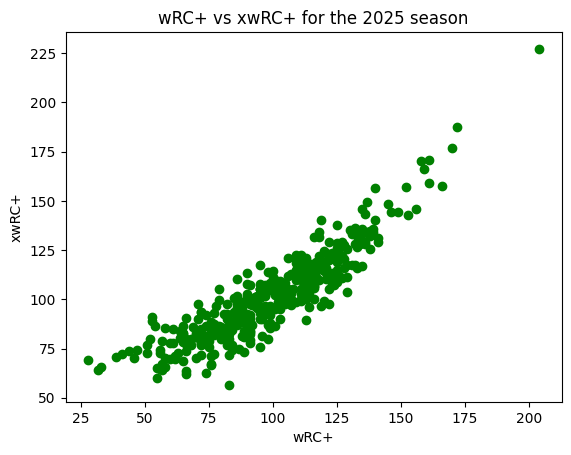

In [ ]:
plt.scatter(data_2025_pred['wRC+'], data_2025_pred['xwRC+'], color='green')
plt.xlabel('wRC+')
plt.ylabel('xwRC+')
plt.title('wRC+ vs xwRC+ for the 2025 season')
plt.show()

In [ ]:
#projections for the 2026 MLB Season:
data_2026 = predict_wrc_plus(2025)
dis_2026 = data_2026[['Name', 'Team', 'wRC+', 'xwRC+', 'Error_Margin']]

R2 score 0.8017678029194566
MSE 123.1987359091635


,Name,Team,wRC+,xwRC+,Error_Margin
0,Aaron Judge,NYY,204,216.705941,12.705941
7,Cal Raleigh,SEA,161,143.323360,-17.676640
38,Bobby Witt Jr.,KCR,130,143.813159,13.813159
2,Shohei Ohtani,LAD,172,179.953227,7.953227
16,Geraldo Perdomo,ARI,138,134.977179,-3.022821
...,...,...,...,...,...
361,Jordan Walker,STL,66,93.766779,27.766779
387,Josh Rojas,CHW,44,56.561629,12.561629
385,Jac Caglianone,KCR,46,69.280277,23.280277
383,LaMonte Wade Jr.,- - -,52,58.558030,6.558030


In [ ]:
dis_2026[['Name', 'wRC+', 'xwRC+', 'Error_Margin']]

,Name,wRC+,xwRC+,Error_Margin
0,Aaron Judge,204,216.705941,12.705941
7,Cal Raleigh,161,143.323360,-17.676640
38,Bobby Witt Jr.,130,143.813159,13.813159
2,Shohei Ohtani,172,179.953227,7.953227
16,Geraldo Perdomo,138,134.977179,-3.022821
...,...,...,...,...
361,Jordan Walker,66,93.766779,27.766779
387,Josh Rojas,44,56.561629,12.561629
385,Jac Caglianone,46,69.280277,23.280277
383,LaMonte Wade Jr.,52,58.558030,6.558030
